In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix, classification_report

#### Read file

In [31]:
df = pd.read_json('data/books_final.json', lines=True)
df = df[df.product_category == 'Books']
df = df[df.total_votes > 5]

#### Add useful columns

In [32]:
df = df.dropna()
df['helpfulness'] = (df.helpful_votes / df.total_votes).round(2)

df['helpful'] = df.helpfulness > 0.8

df['review_length'] = df['review_body'].apply(len)
df = df[df.review_length <= 5000]

#### Stats

In [33]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

total count
316018

helpful count
150194

not helpful count
165824

average helpfulness
0.7015638666154201

average length of helpful review
1282.837250489367

average length of not helpful review
974.5342773060594


#### Only extreme reviews

In [ ]:
df = df[(df.helpfulness < 0.2) | (df.helpfulness > 0.99)]
df['helpful'] = df.helpfulness > 0.8

#### Extreme review stats

In [ ]:
# count: 
print("total count")
print(df.customer_id.count())

# Num helpful:
print("\nhelpful count")
print(df[df['helpful'] == True].customer_id.count())

# Num not helpful: 
print("\nnot helpful count")
print(df[df['helpful'] == False].customer_id.count())

# average helpfulness score:
print("\naverage helpfulness")
print(df.helpfulness.mean())

# average length of helpful review
print("\naverage length of helpful review")
print(df[df.helpful == True].review_length.mean())

#  average length of not helpful review
print("\naverage length of not helpful review")
print(df[df.helpful == False].review_length.mean())

# Analyse factors vs helpfulness

#### Review length

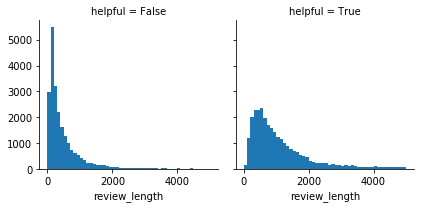

In [13]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'review_length', bins=50)

#### Star rating

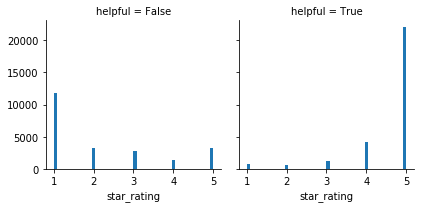

In [14]:
g = sns.FacetGrid(data=df, col='helpful')
g.map(plt.hist, 'star_rating', bins=50)

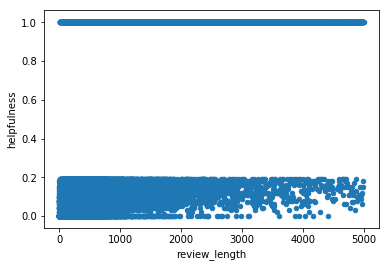

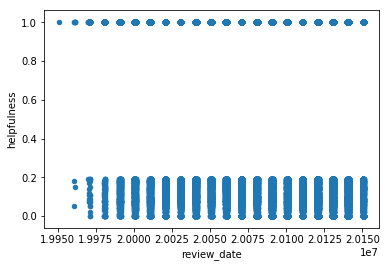

In [15]:
df.plot.scatter(x='review_length',y='helpfulness')
df['review_date'] = pd.to_datetime(df["review_date"]).dt.strftime("%Y%m%d").astype(int)
df.plot.scatter(x='review_date',y='helpfulness')

#### Verified purchase

In [16]:
ver = df[df.verified_purchase == 'Y']
not_ver = df[df.verified_purchase == 'N']

print("avg helpfulness of verified purchases: {0}".format(ver.helpfulness.mean()))
print("avg helpfulness of unverified purchases: {0}".format(not_ver.helpfulness.mean()))

avg helpfulness of verified purchases: 0.589133526612337
avg helpfulness of unverified purchases: 0.6144371608024892


# Predicting using Naive Bayes

In [17]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    '''
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') and len(word) > 3]

In [18]:
X = df['review_body']
Y = df['helpful']

In [19]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [20]:
X = bow_transformer.transform(X)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

### MultinomialNB

In [22]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
preds = nb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[4181 2512]
 [ 523 8108]]


              precision    recall  f1-score   support

       False       0.89      0.62      0.73      6693
        True       0.76      0.94      0.84      8631

   micro avg       0.80      0.80      0.80     15324
   macro avg       0.83      0.78      0.79     15324
weighted avg       0.82      0.80      0.79     15324



#### ComplementNB 

In [24]:
cnb = ComplementNB()
cnb.fit(X_train, Y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [25]:
preds = cnb.predict(X_test)

print(confusion_matrix(Y_test, preds))
print('\n')
print(classification_report(Y_test, preds))

[[4348 2345]
 [ 539 8092]]


              precision    recall  f1-score   support

       False       0.89      0.65      0.75      6693
        True       0.78      0.94      0.85      8631

   micro avg       0.81      0.81      0.81     15324
   macro avg       0.83      0.79      0.80     15324
weighted avg       0.83      0.81      0.81     15324



#### Manual examination

In [26]:
df[df.helpfulness > 0.1].sort_values('helpfulness').head(1)

,customer_id,helpful_votes,product_category,product_id,review_body,review_date,review_id,star_rating,total_votes,verified_purchase,helpfulness,helpful,review_length
209430,21553738,9,Books,B00A19TMNG,"Why waste my time with an immature, ignorant i...",20140511,R25U4HOTLDS5VQ,1,82,N,0.11,False,161


In [27]:
mid_review = df['review_body'][2808]
mid_review_transformed = bow_transformer.transform([mid_review])
print("predicted helpful: {0}, actual helpfulness: {1}".format(nb.predict(mid_review_transformed)[0],df['helpfulness'][2808]))

KeyError: 2808

#### Popular products

In [ ]:
df.product_id.value_counts(ascending=False).head(6)

In [ ]:
df_1 = df[df.product_id == 'B00LFT0CEO']
df_2 = df[df.product_id == 'B002W2HIYA']
df_3 = df[df.product_id == 'B00IAMTLS2']
df_4 = df[df.product_id == 'B00064LO3C']
df_5 = df[df.product_id == 'B002VBE6N8']
df_6 = df[df.product_id == 'B00005JHWB']

gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (2, 0))
ax4 = plt.subplot2grid(gridsize, (0, 1))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 1))

for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.set_xticks([])

sctr = ax1.scatter(x = df_1.review_date, y = df_1.helpfulness)
sctr = ax2.scatter(x = df_2.review_date, y = df_2.helpfulness)
sctr = ax3.scatter(x = df_3.review_date, y = df_3.helpfulness)
sctr = ax4.scatter(x = df_4.review_date, y = df_4.helpfulness)
sctr = ax5.scatter(x = df_5.review_date, y = df_5.helpfulness)
sctr = ax6.scatter(x = df_6.review_date, y = df_6.helpfulness)